# Create a Custom PowerPoint Presentation of Satellite Course Slides

> History | Updated Jan 2026 
> Authors | Madison Richardson, Sunny Hospital, and Dale Robinson  
> Affiliation | UC Santa Cruz, in collaboration with NOAA CoastWatch West Coast

## Introduction

CoastWatch has collected informational slides from many of the participant who have taken the CoastWatch Satellite Training Course. The slides outline what each person worked on during the course and what they accomplished. The slide collection is stored in a password-protected ERDDAP dataset as .PNG files.  

We paired the participant slides with additional information about each participant that was collected during the course registration process. This information was uploaded into a separate password-protected metadata "data base" in the form of an ERDDAP tabledap dataset. The dataset is queryable by categories like the course's name and year it was offered, as well as the participants name, affiliation, satellite products of interests, and software use. The result of a query is a listing of participant slide IDs that match your search criteria along with the associated metadata. This information is valuable for reports and presentations that document the reach and impact of the CoastWatch Satellite Training Courses. 

This Python tutorial shows how to **generate a PowerPoint presentation of participant slides** by downloading slides from the slide collection dataset based on the output from a query to the course metadata dataset. 


**Two ways to obtain the metadata**

This tutorial supports two equivalent approaches for obtaining the metadata used to select participant slides:

- **Option 1**  downloads the complete metadata table from ERDDAP and performs all filtering locally in Python. This approach is best for reproducible workflows, automation, and users who want maximum flexibility when filtering or reusing the metadata.

- **Option 2** uses the ERDDAP web interface to visually subset the metadata and generate a query URL. This approach is useful for first-time users who want to explore the available metadata fields or prefer a graphical interface.

Both options produce the same type of metadata table and lead into the same downstream workflow. Users may choose the option that best fits their experience level and use case.

In this tutorial, we used Option 1.

## Resources

In order to run this tutorial, you will need:

- Python 3

- Jupyter Notebook

- Internet Connection

- Microsoft PowerPoint

## Data sets
- The course slide metadata dataset is at the following location:  
  https://coastwatch.pfeg.noaa.gov/wcn/erddap/tabledap/satellite_course_slides_metadata

- The archive of course slides is at the following location:  
  https://coastwatch.pfeg.noaa.gov/wcn/erddap/tabledap/course_slide_deck.html

  You can directly download the slide images from the files path in ERDDAP:  
  https://coastwatch.pfeg.noaa.gov/wcn/erddap/files/course_slide_deck/

## Load Required Packages

In [29]:
import os
import requests
import urllib
import re
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from io import BytesIO
from pptx import Presentation
from pptx.util import Inches, Pt
from pptx.enum.text import PP_ALIGN
from PIL import Image, ImageOps
import time
import pickle  # To store/reuse cookies
import concurrent.futures  # For parallel downloads

from selenium import webdriver
from selenium.webdriver.chrome.service import Service
from webdriver_manager.chrome import ChromeDriverManager

## Make Some Useful Functions

In [2]:
def authenticate_session_selenium(login_url):
    """
    Open a browser for ERDDAP authentication and return
    an authenticated requests.Session.

    The function pauses execution until the user confirms
    that ALL login steps (Google + ERDDAP) are complete.
    """

    driver = webdriver.Chrome(
        service=Service(ChromeDriverManager().install())
    )

    driver.get(login_url)

    print("""
AUTHENTICATION REQUIRED

A browser window has opened.

Please complete ALL login steps:
1) Google login (email + 2FA)
2) ERDDAP confirmation ("Continue as ...")

Do NOT close the browser window.
""")

    input(" Press ENTER here only AFTER the ERDDAP interface has fully loaded...")

    cookies = driver.get_cookies()
    driver.quit()

    session = requests.Session()
    for c in cookies:
        session.cookies.set(c["name"], c["value"])

    return session

In [3]:
def authenticate_session_manual(cookie_header: str):
    """
    Manually authenticates a session using a copied cookie string.

    Args:
        cookie_header (str): A string of cookies in "key=value; key2=value2" format.

    Returns:
        requests.Session: Authenticated session object with headers.
    """
    session = requests.Session()
    session.headers.update({
        "Cookie": cookie_header
    })
    return session

In [4]:
def download_csv_with_auth(session, file_url):
    """
    Download and read CSV data using an authenticated session.

    The functions sends a GET request to the specified
    URL using the provided authenticated session. If the request
    is successful (HTTP 200), the response content is read into
    a Pandas Dataframe.

    Args:
        session (requests.Session): An authenticated session object with necessary headers.
        file_url (str): The URL of the CSV file to be downloaded.

    Returns:
        pandas.DataFrame: A DataFrame containing the CSV data if the request is successful.
        None: If the request fails.

    """
    response = session.get(file_url)

    if response.status_code == 200:
        print("Successfully retrieved ERDDAP CSV data")
        # data = pd.read_csv(BytesIO(response.content))
        data = pd.read_csv(BytesIO(response.content), header=0, skiprows=[1])
        return data
    else:
        print(f"Failed to retrieve data. Status Code: {response.status_code}")

In [5]:
def get_unique_values(df, column_name):
    """
    Extract and return a sorted list of unique values from
    a column with comma-separated strings.

    Args:
        df (Pandas.DataFrame): The input DataFrame.
        column_name (str): Name of the column to process.

    Returns:
        list: Sorted list of unique cleaned values.
    """

    if column_name not in df.columns:
        raise ValueError(f"Column '{column_name}' not found in dataset.")

    # Drop missing values, split by commas, flatten_list, strip whitespace
    cleaned_values = [
        item.strip()
        for entry in df[column_name].dropna()
        for item in str(entry).split(",")
    ]

    # Return sorted unique values
    return sorted(set(cleaned_values))

In [6]:
def lollipop_chart_from_column(
    df, column_name, title="Lollipop Chart", color="#0072ce", figsize=(8, 6)
):
    """
    Create a lollipop chart showing the frequency of
    unique values in a comma-separated text column of
    a pandas DataFrame.

    Args:
        df (pd.DataFrame): The DataFrame containing the column to analyze.
        column_name (str): The name of the column in the DataFrame.
        title (str, optional): The title to display at the top of the chart. Defaults to "Lollipop Chart".
        color (str, optional): The color of the lollipop points. Defaults to '#0072ce'.
        figsize (tuple, optional): The size of the matplotlib figure. Defaults to (8, 6).
    """

    # Process column: split by commas, strip whitespace
    value_series = (
        df[column_name]
        .dropna()
        .astype(str)
        .str.split(",")
        .explode()
        .str.strip()
    )

    # Count frequency
    counts = (
        value_series.value_counts()
        .rename_axis(column_name)
        .reset_index(name="Frequency")
    )

    # Sort and assign range
    ordered = counts.sort_values(by="Frequency")
    my_range = range(1, len(ordered) + 1)

    # Plot
    plt.figure(figsize=figsize)
    plt.hlines(
        y=my_range,
        xmin=0,
        xmax=ordered["Frequency"],
        color="skyblue",
        linewidth=2,
    )
    plt.plot(ordered["Frequency"], my_range, "o", color=color)

    plt.yticks(my_range, ordered[column_name])
    plt.xlabel("Frequency")
    plt.title(title, loc="left")
    plt.tight_layout()
    plt.show()

In [7]:
def filter_slide_columns(df, keywords, column="SlideTopic"):
    """
    Filter a DataFrame for rows where a specific column contains
    any of the given keywords (case-insensitive, partial match).

    Args:
        df (pd.DataFrame): The input metadata DataFrame.
        keywords (list of str): Keywords to match (e.g., ["SST", "Chlorophyll"]).
        column (str): The column name to search in.

    Returns:
        pd.DataFrame: A filtered DataFrame containing only rows that match at least one keyword.
    """
    if column not in df.columns:
        raise ValueError(f"Column '{column}' not found in the DataFrame.")

    # Build regex pattern (e.g., "SST|Chlorophyll")
    pattern = "|".join(re.escape(k) for k in keywords)

    # Case-insensitive search using str.contains
    filtered_df = df[
        df[column].str.contains(pattern, case=False, na=False, regex=True)
    ]

    return filtered_df

In [8]:
def download_image(session, image_url):
    """
    Download an image using an authenticated session.

    The function sends a GET request to the specified image
    URL using the provided authenticated session. If the request is successful (HTTP 200),
    the image content is returned as a BytesIO object.

    Args:
        session (requests.Session): An authenticated session object with necessary headers.
        image_url (str): The URL of the image to be downloaded.


    Returns:
        BytesIO: A BytesIO object containing the image data if the request is successful.
        None: If the request fails.

    """
    response = session.get(image_url)
    if response.status_code == 200:
        return BytesIO(response.content)
    else:
        print(f"Failed to download image: {image_url}")
        return None

In [9]:
def parallel_download_images(session, slide_urls):
    """
    Download images in parallel using multithreading.

    The function uses a ThreadPoolExecutor to download
    multiple images in parallel, significantly reducing
    download time compared to sequential requests. Each
    image is fetched using the `download_image` function
    and stored in a dictionary.

    Args:
        session (requests.Session): An authenticated session object with necessary headers.
        slide_urls (list of str): A list of image URLs to be downloaded.


    Returns:
        dict: A dictionary where keys are image URLs and values are BytesIO objects
        containing the image data.

    """
    images = {}

    def fetch(url):
        img_data = download_image(session, url)
        if img_data:
            images[url] = img_data

    with concurrent.futures.ThreadPoolExecutor(max_workers=10) as executor:
        executor.map(fetch, slide_urls)

    return images

## Option 1: Manually build ERDDAP metadata dataset
### Step 1 - Build a minimal ERDDAP URL (no filters yet)
Instead of specifying individual variables or constraints, we request the entire metadata table in one call. For ERDDAP tabledap datasets, omitting the variable list returns all available columns by default.

In [10]:
# ERDDAP server and dataset
server_base = "https://coastwatch.pfeg.noaa.gov/wcn/erddap"
dataset_id = "satellite_course_slides_metadata"

# Request ALL variables by omitting the variable list
metadata_url = f"{server_base}/tabledap/{dataset_id}.csv"

print(metadata_url)


https://coastwatch.pfeg.noaa.gov/wcn/erddap/tabledap/satellite_course_slides_metadata.csv


## Option 1:
### ERDDAP authentication
To login into the ERDDAP server, begin by click the **Sign in with Google** button in the red box labeled #1. This will prompt you to sign in with email and password, followed by 2-step verification. Once authenticated, click the **login** button shown in the red box labeled #2. After clicking, you should see a prompt such as "Continue as [Your Name]". The process starts up a browser within Python, and sets a cookie. Then the cookie is retrieved to allow downloads from a password protected dataset.

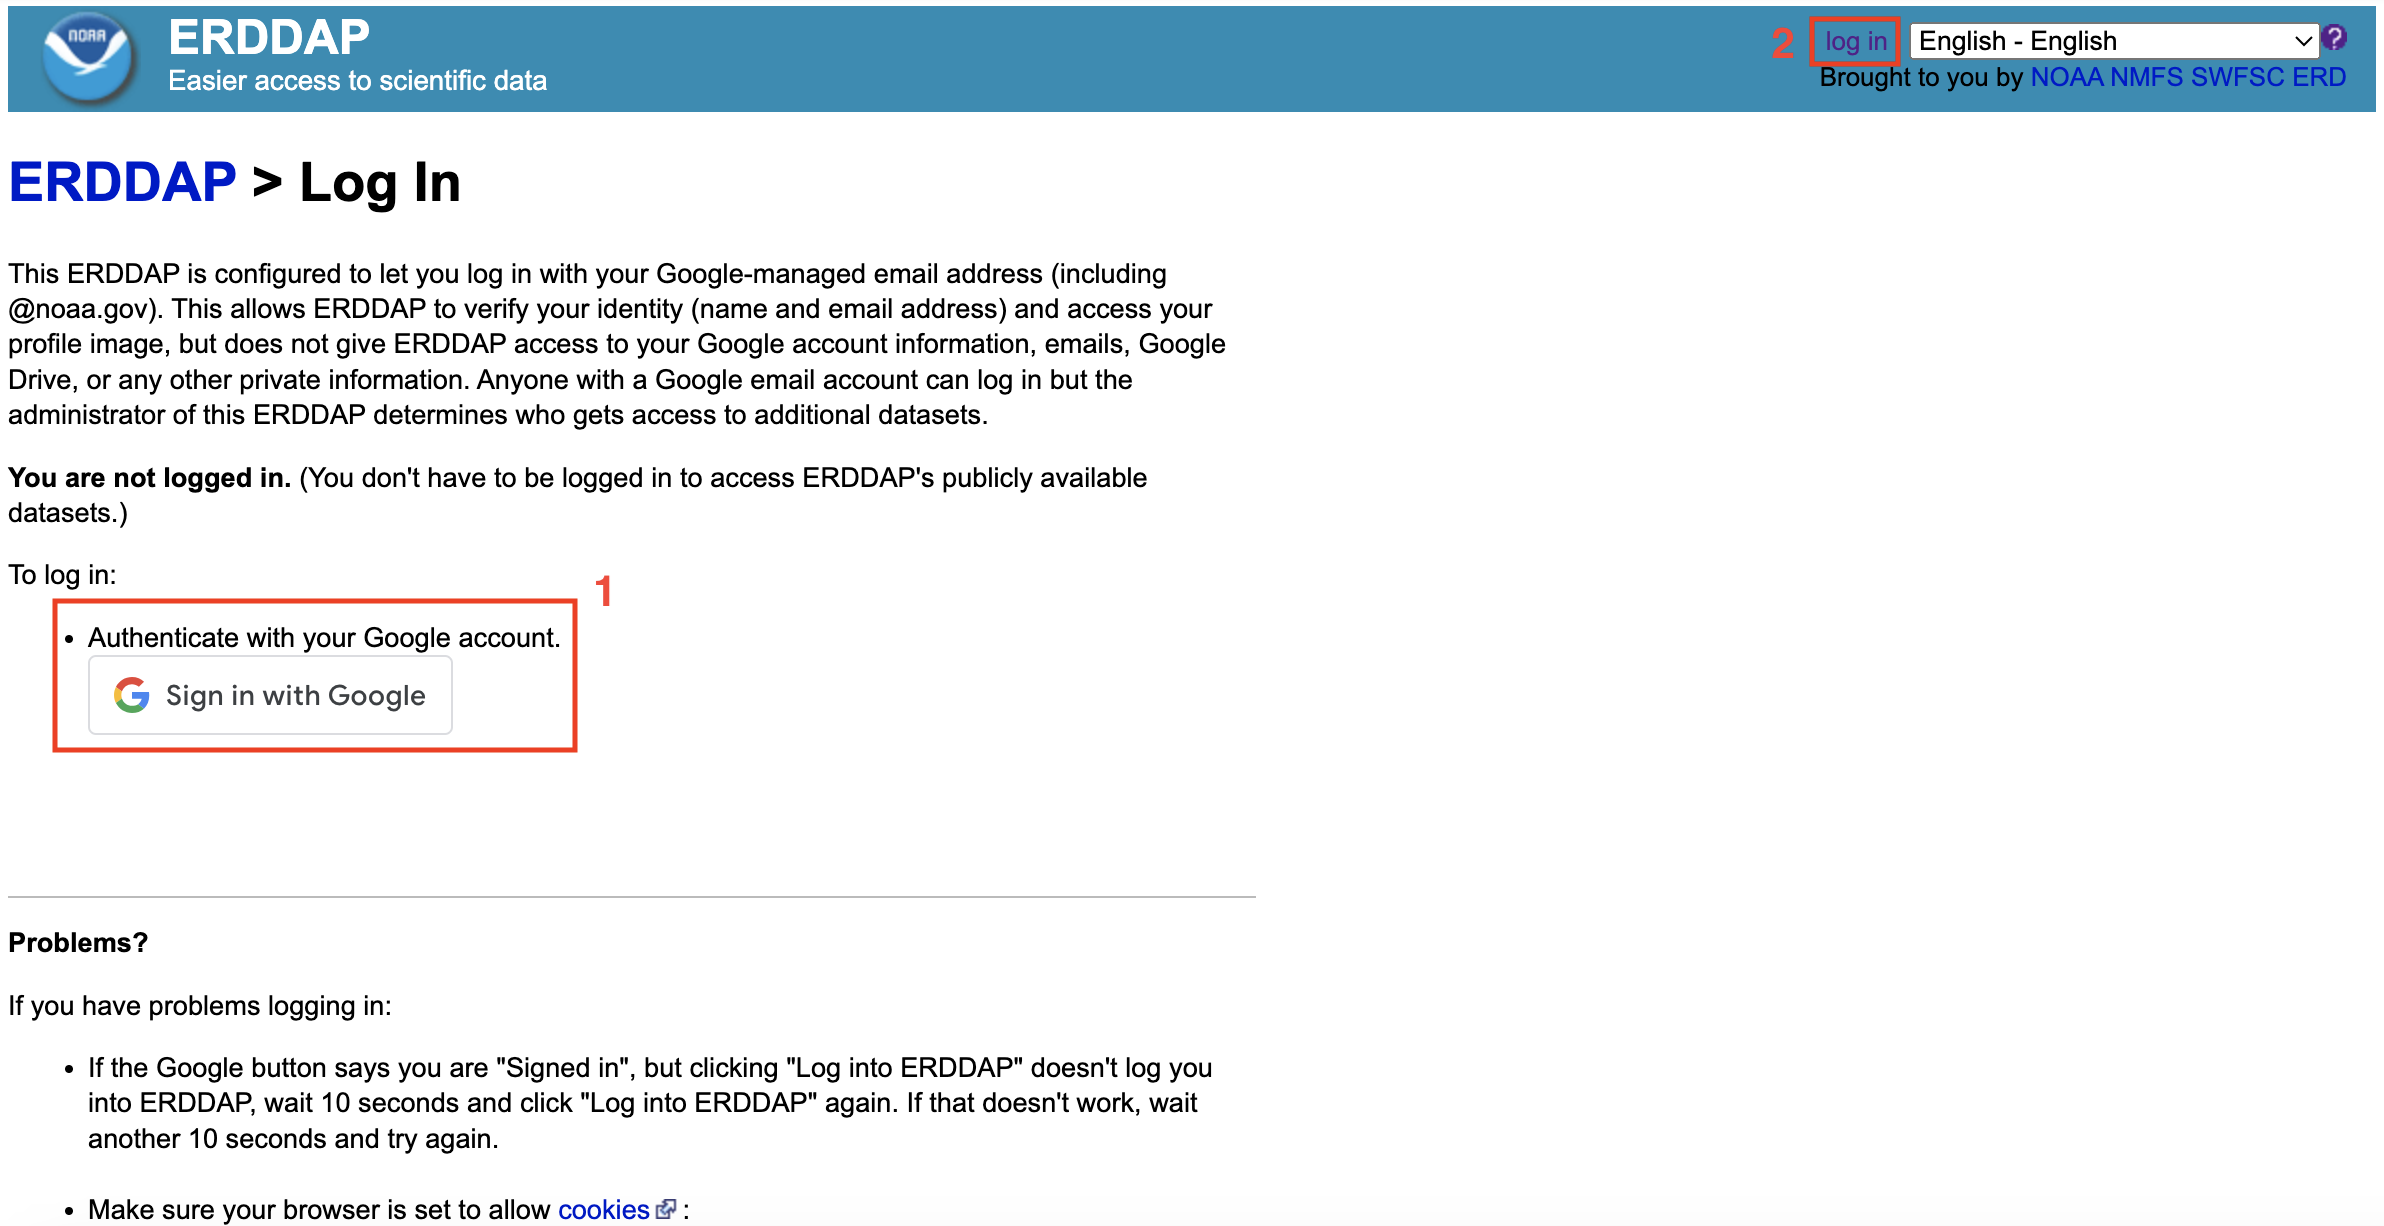

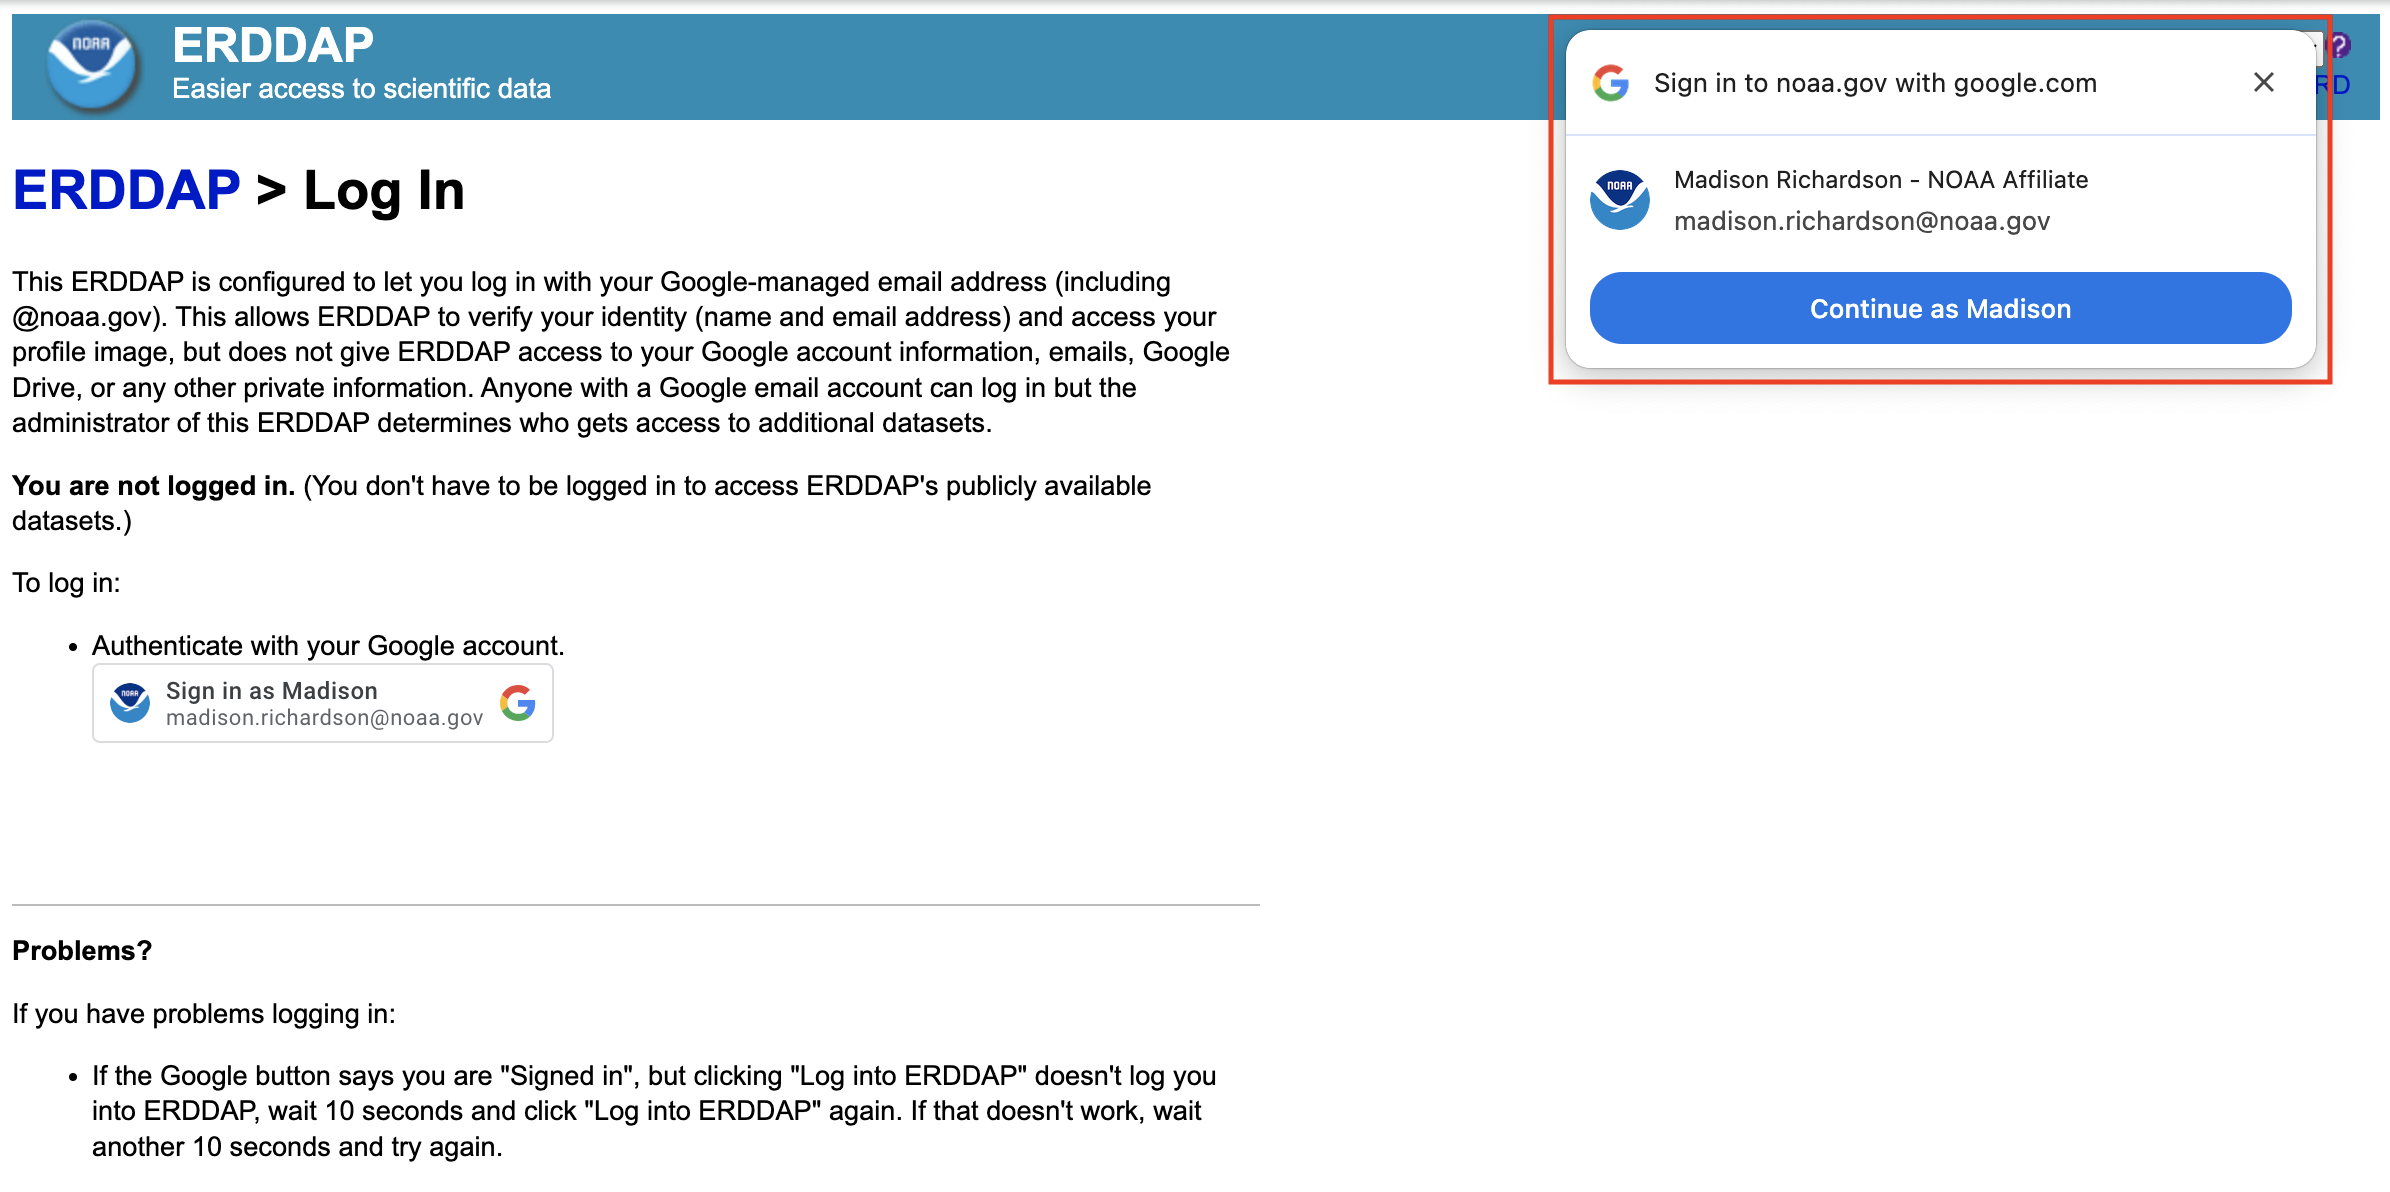

### Step 2 - Authenticate and download the full metadata total
Because this dataset is password-protected, authentication is required before downloading the metadata.
The authentication process opens a browser window, completes the NOAA Google login, and stores a session cookie for use in Python.

Once authenticated, the entire metadata table is downloaded into a pandas DataFrame.


In [11]:
login_url = "https://coastwatch.pfeg.noaa.gov/wcn/erddap/login.html"
session = authenticate_session_selenium(login_url)


AUTHENTICATION REQUIRED

A browser window has opened.

Please complete ALL login steps:
1) Google login (email + 2FA)
2) ERDDAP confirmation ("Continue as ...")

Do NOT close the browser window.



In [12]:
# Download metadata CSV using an authenticated session
metadata_df = download_csv_with_auth(session, metadata_url)

# Exit if the data could not be retrieved
if metadata_df is None:
    print("the data could not be retrieved")
    exit(1)

# Clean column names by stripping whitespace
metadata_df.columns = metadata_df.columns.str.strip()

# Display available columns
print("Columns in metadata dataset:", metadata_df.columns.tolist())

Successfully retrieved ERDDAP CSV data
Columns in metadata dataset: ['ID', 'First_Name', 'Last_Name', 'Course_ID', 'Year', 'Country', 'Affiliation', 'Affiliation_Type', 'NOAA_LO', 'sub_NOAA_LO', 'Title', 'Products', 'Topic', 'Software', 'JPSS', 'NOAA', 'Slide']


## Option 1
### Step 3 - Filter rows locally

With the full metadata table available locally, we apply filters using standard pandas logic. For this example, we selected "Affiliation_Type"=**NOAA**, NOAA_LO=**NMFS**, and "JPSS"=**yes**.


In [13]:
filtered_metadata = metadata_df[
    (metadata_df["Affiliation_Type"] == "NOAA") &
    (metadata_df["NOAA_LO"] == "NMFS") &
    (metadata_df["JPSS"] == "yes")
]

## Option 1
### Step 4 - Select only the columns we are interested in  
Although all metadata fields were downloaded, only a subset is required for visualization and slide generation.
We now narrow the DataFrame to the columns we need:


In [14]:
metadata_df = filtered_metadata[
    ["ID", "Year", "Affiliation", "Products", "Topic"]
]

print(metadata_df)

             ID  Year          Affiliation                   Products  \
160    2013wcn2  2013      NMFS/NWFSC/FRAM               Model Output   
163   2013wcn22  2013           NMFS/SWFSC           SST, SST Anomaly   
166   2013wcn25  2013           NMFS/SWFSC                        NaN   
177   2013wcn35  2013  NMFS/NEFSC/READ/PSB                Ocean Color   
180    2013wcn6  2013           NMFS/SEFSC                Ocean Color   
195    2014wcn2  2014       NMFS/NWFSC/FED                Ocean Color   
199    2014wcn5  2014           NMFS/SEFSC                Ocean Color   
204    2015wcn1  2015           NMFS/SWFSC           SST, Ocean Color   
222   2016wcn17  2016           NMFS/SEFSC                Ocean Color   
228   2016wcn22  2016      NMFS/AFSC/REFMD                Ocean Color   
242   2016wcn35  2016           NMFS/SWFSC           SST, Ocean Color   
244    2016wcn5  2016       NMFS/AFSC/RACE                Ocean Color   
258   2017wcn18  2017       NMFS/NWFSC/CBD         

## 🚫 Skip Option 2 if you completed Option 1

If you followed Option 1, you already have the required metadata_df.
Skip all cells labeled “Option 2” and continue at the section marked:

**START HERE AFTER OPTION 1**


## Option 2: Query the ERDDAP metadata dataset

* Open the ERDDAP login page in a browser: https://coastwatch.pfeg.noaa.gov/wcn/erddap/loginGoogle.html
* After you log into ERDDAP using your NOAA account, navigate to the dataset: **satellite_course_slides_metadata**. Then click on the subset link.
* Use the dropdown menus to customize your query (See screenshot below). For this example, we selected "Affiliation_Type"=**NOAA**, NOAA_LO=**NMFS**, and "JPSS"=**yes**.
* A preview of the results of your query selection can be viewed at the bottom of the page. 
* Once your query selections are made, click on the **Data Access Form** link.   

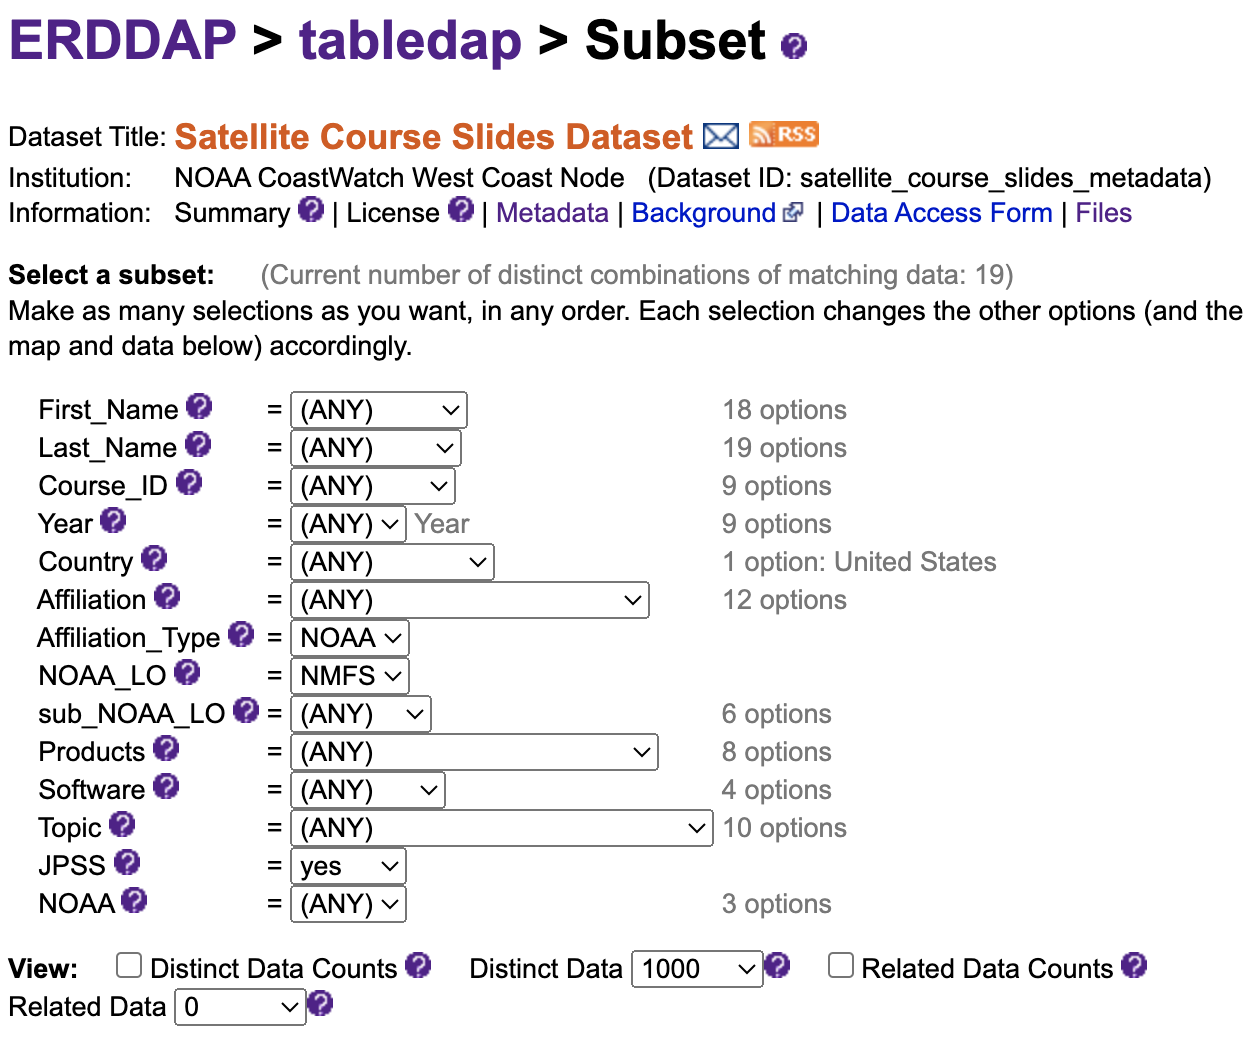

## Option 2: Obtain the ERDDAP data request URL for your query

On the **Data Access Form** page, you will see that the choices you made on the subset page now populate the Data Access Form. 

- On the left side of the page, a column labeled **Variable** is the list of all metadata items you can download. Unchecking the checkbox will remove the item from the download request and checking an item will add the item from the download request.  
- For this example, we will uncheck everything except **ID**, **Year**, **Affiliation**, and **Topic**. You may choose a different set of metadata items to download. 
- Make sure that **ID** is checked because it is needed to locate the correct slides to download.
- Make sure that you also select 'yes' on the **Slide** dropdown to limit query results to rows that have course slides.
- Next select **.csv** from the **File type** dropdown. 
- Now click the **Just generate the URL** button. A URL will be generated in the text box to the right of the button.  
- Copy the URL. It is the ERDDAP data request you will use with Pandas to download the metadata you selected.

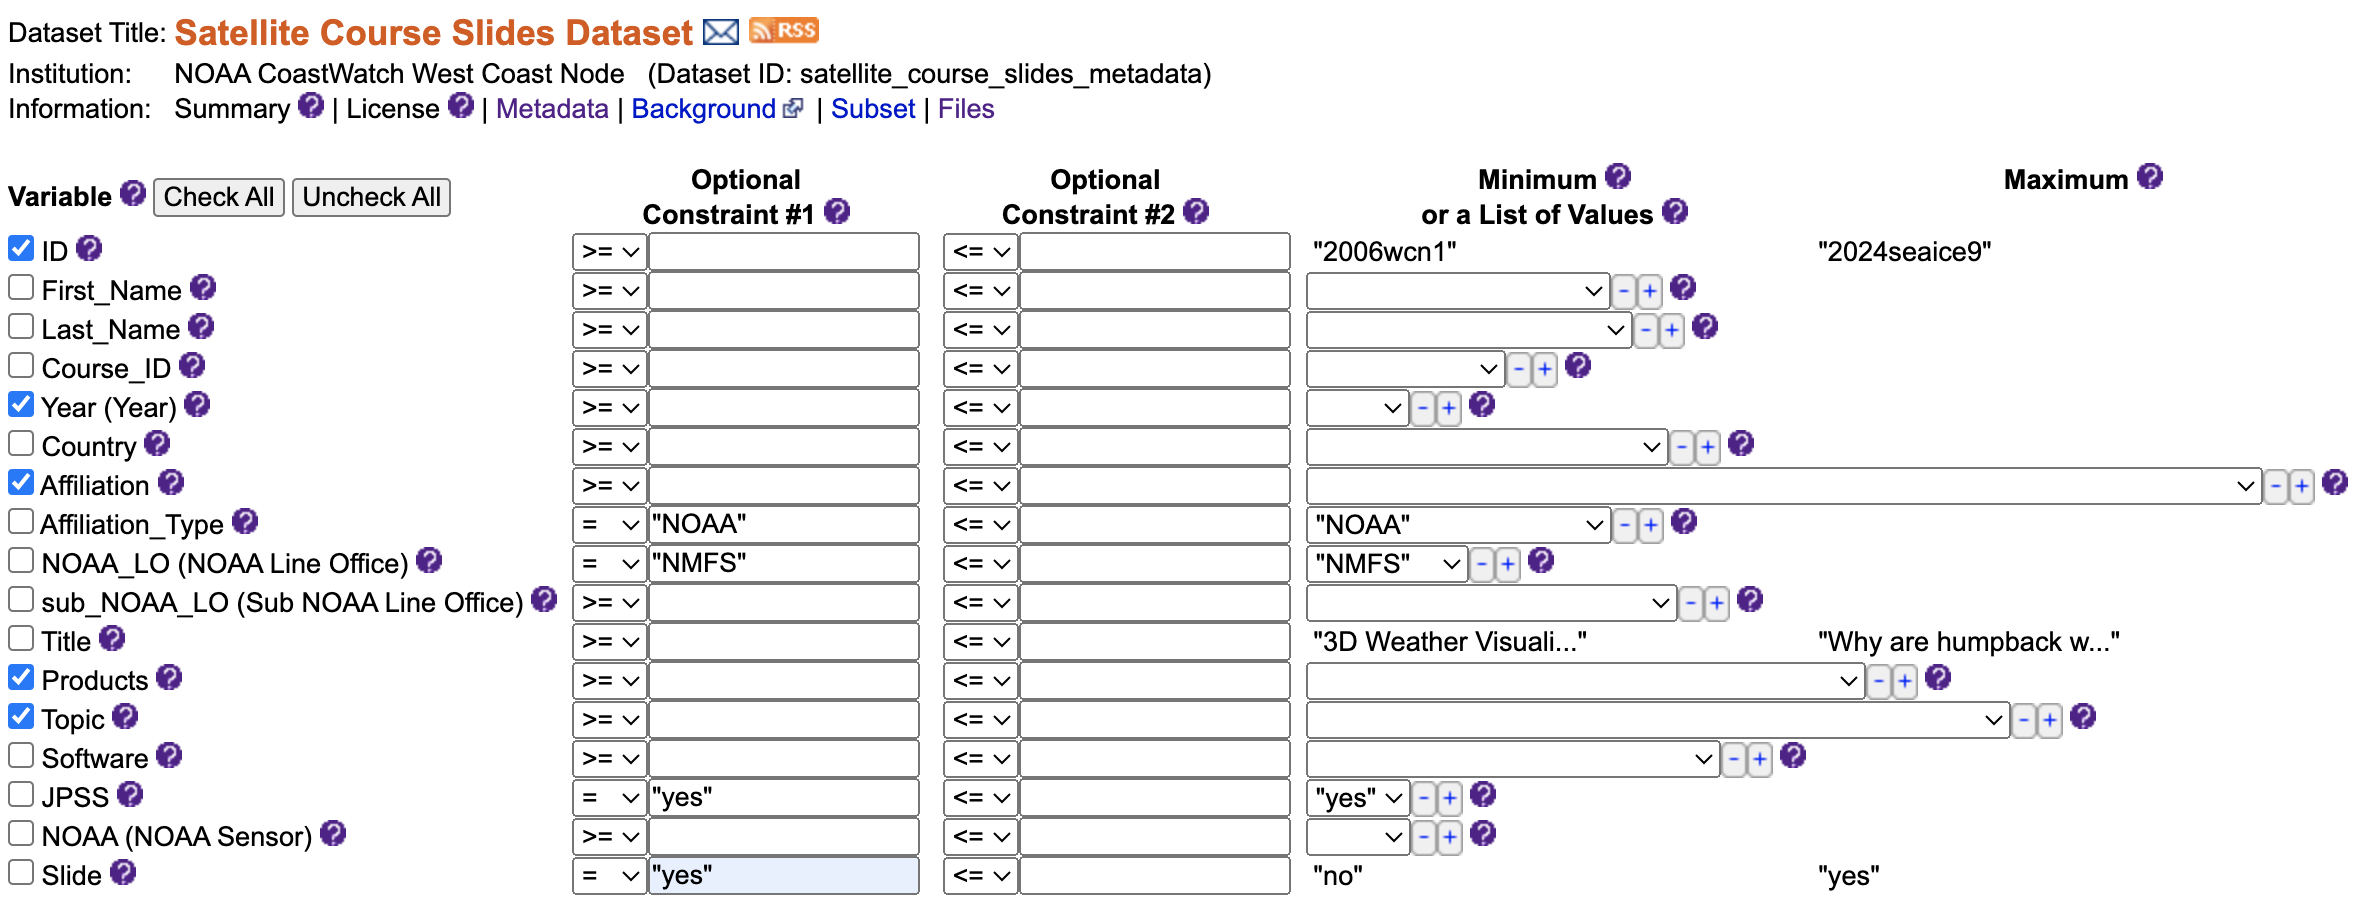

### Put the copied URL as the value for the **metadata_url** variable (below in the next cell) for safe keeping. 
We will use it in step 2 of the "Get the metadata selected in your query" section below.

In [22]:
## The is preloaded with the URL from this example.
## Replace it with your URL if you selected different metadata
metadata_url = "https://coastwatch.pfeg.noaa.gov/wcn/erddap/tabledap/satellite_course_slides_metadata.csv?ID%2CYear%2CAffiliation%2CProducts%2CTopic&Affiliation_Type=%22NOAA%22&NOAA_LO=%22NMFS%22&JPSS=%22yes%22"

## Option 2: Get the metadata selected in your query
#### Obtaining the data is a two step process

### 1. ERDDAP authentication
Although you logged in to the ERDDAP server already, you will need to do it again within Python. 

To login into the ERDDAP server, begin by click the **Sign in with Google** button in the red box labeled #1. This will prompt you to sign in with email and password, followed by 2-step verification. Once authenticated, click the **login** button shown in the red box labeled #2. After clicking, you should see a prompt such as "Continue as [Your Name]". The process starts up a browser within Python, and sets a cookie. Then the cookie is retrieved to allow downloads from a password protected dataset.

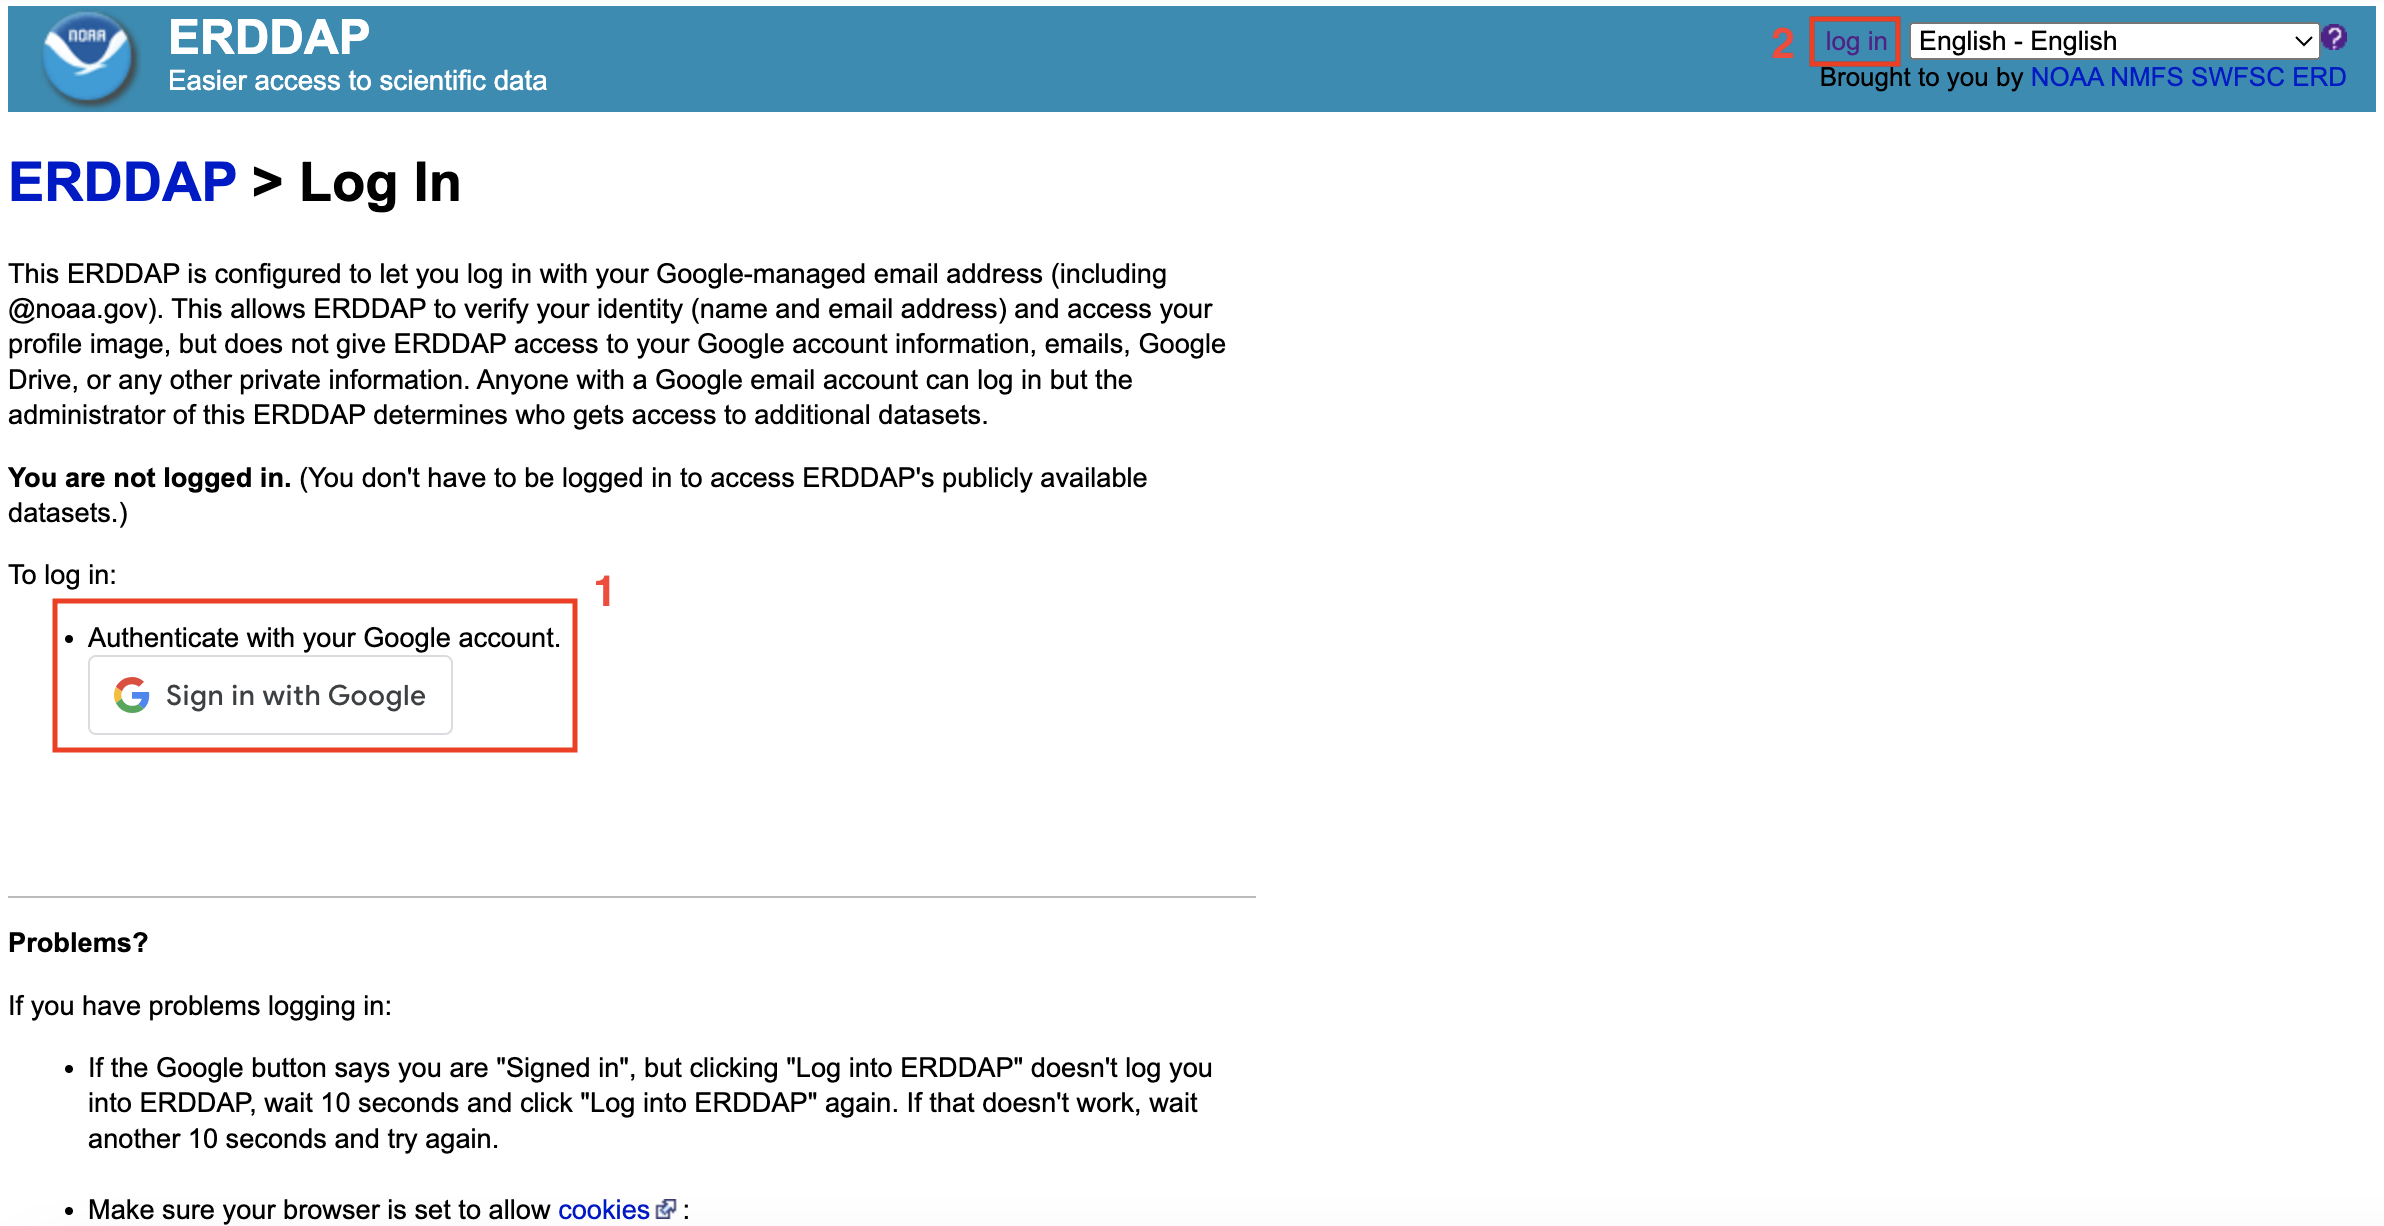

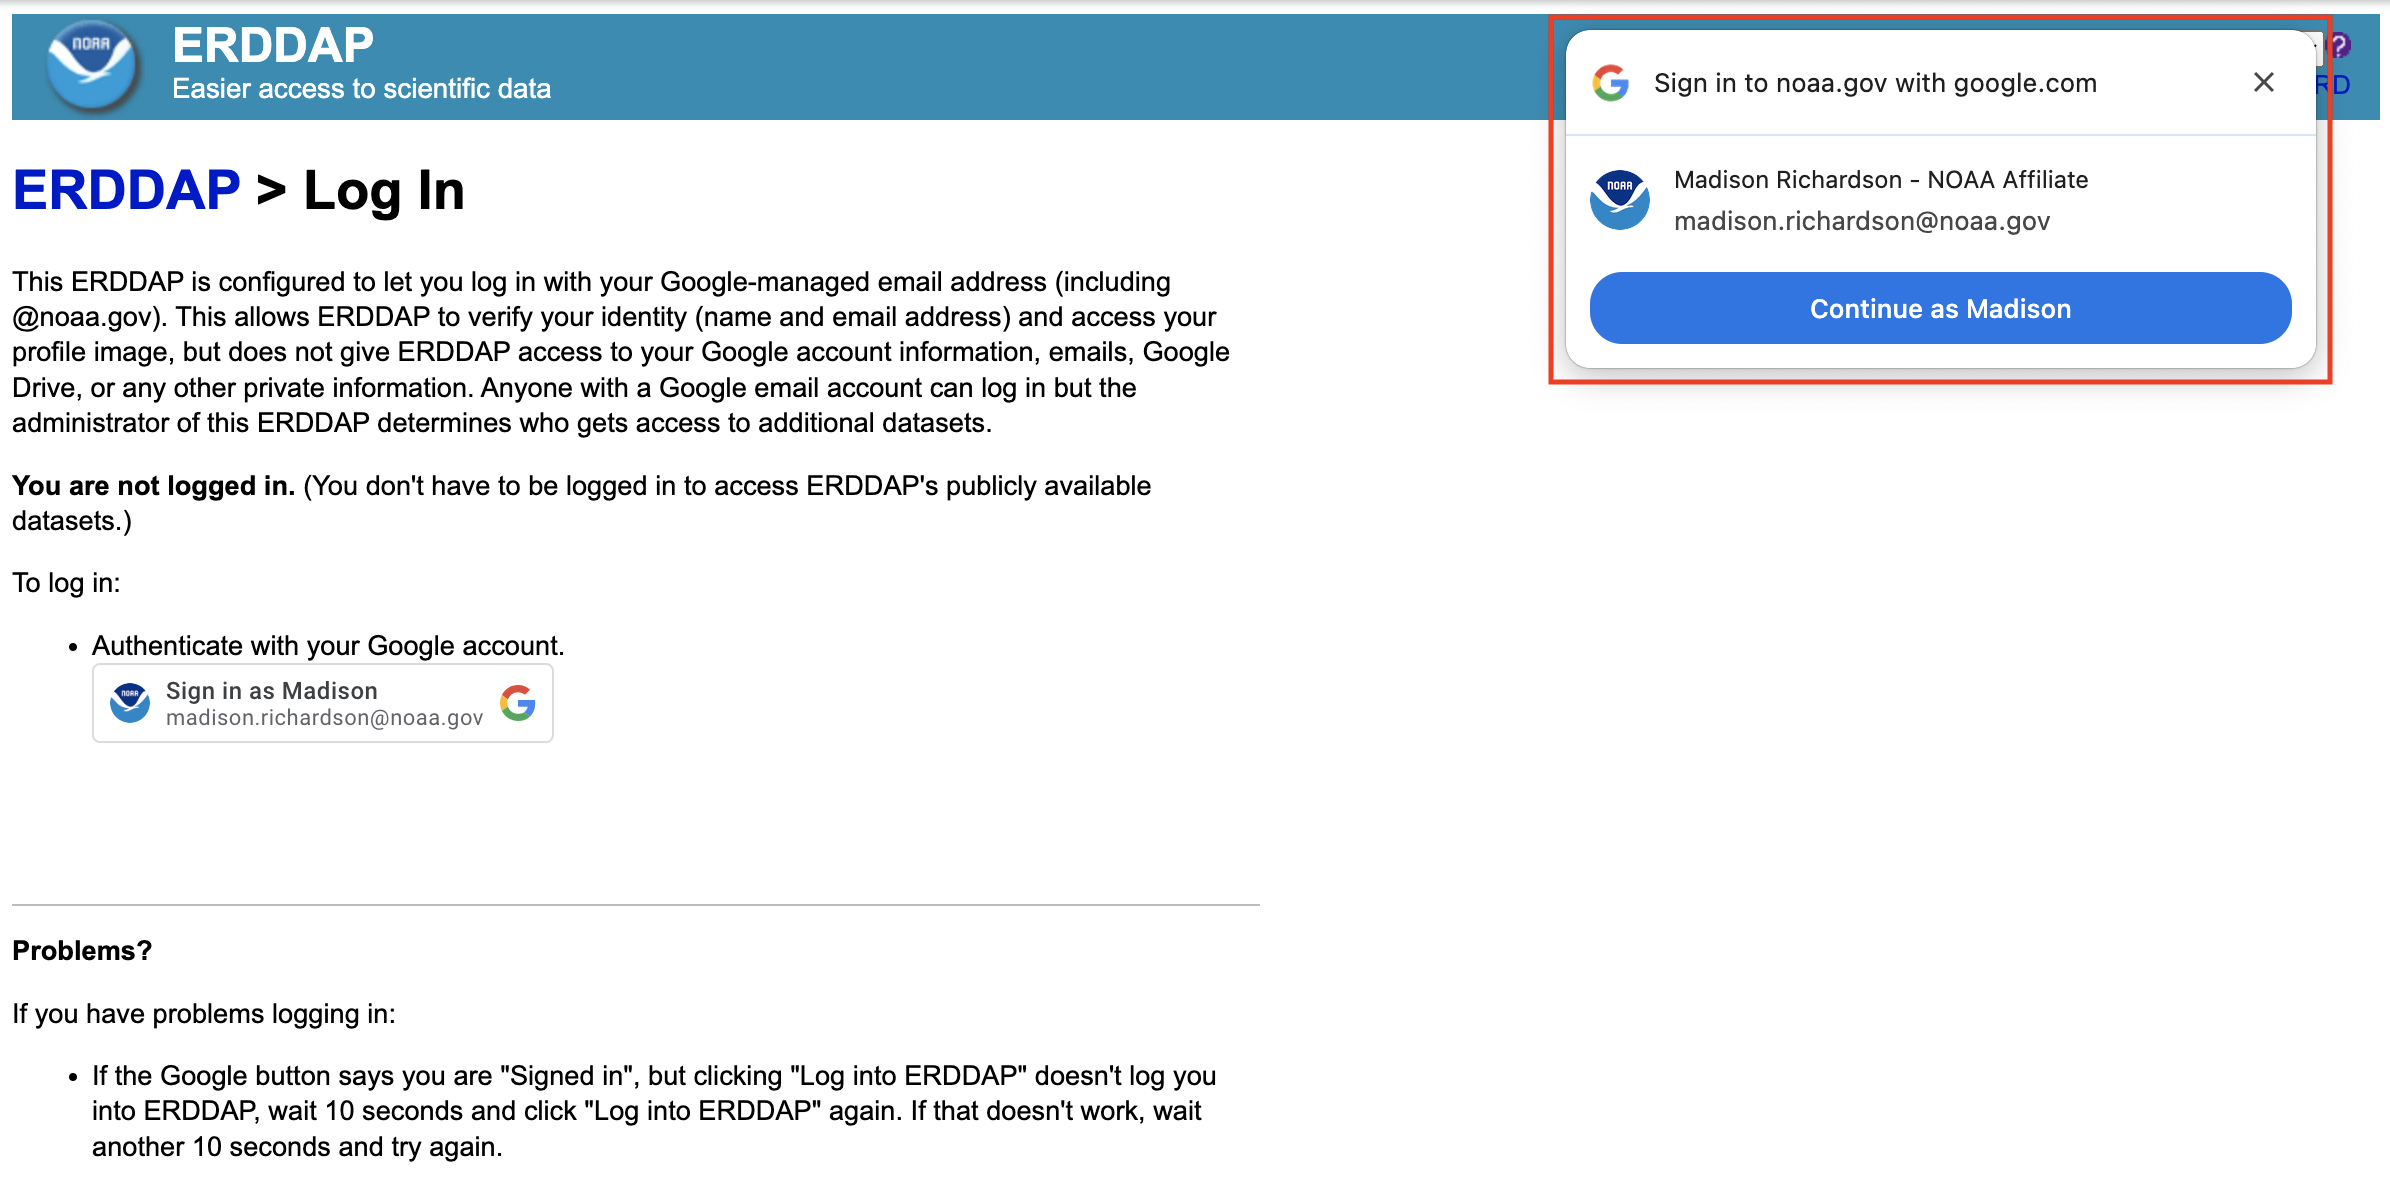

In [24]:
login_url = "https://coastwatch.pfeg.noaa.gov/wcn/erddap/login.html"
session = authenticate_session_selenium(login_url)


AUTHENTICATION REQUIRED

A browser window has opened.

Please complete ALL login steps:
1) Google login (email + 2FA)
2) ERDDAP confirmation ("Continue as ...")

Do NOT close the browser window.



## Option 2
### 2. Download the metadata
The cookie is used to obtain a response from the from the password-protected metadata dataset, using the ERDDAP request URL (metadata_url) you generated earlier. The response is fed to the Pandas **read_csv** function to bring the metadata into a Pandas dataframe.  

In [25]:
# ERDDAP metadata URL for satellite course slides
# metadata_url = "https://coastwatch.pfeg.noaa.gov/wcn/erddap/tabledap/satellite_course_slides_metadata.csv?ID%2CYear%2CAffiliation%2CProducts%2CTopic&Affiliation_Type=%22NOAA%22&NOAA_LO=%22NMFS%22&JPSS=%22yes%22"

# Download metadata CSV using an authenticated session
metadata_df = download_csv_with_auth(session, metadata_url)

# Exit if the data could not be retrieved
if metadata_df is None:
    print("the data could not be retrieved")
    exit(1)

# Clean column names by stripping whitespace
metadata_df.columns = metadata_df.columns.str.strip()

# Display available columns
print("Columns in metadata dataset:", metadata_df.columns.tolist())

Successfully retrieved ERDDAP CSV data
Columns in metadata dataset: ['ID', 'Year', 'Affiliation', 'Products', 'Topic']


## START HERE AFTER OPTION 1

## View Unique Values in Columns of the Metadata

Explore the unique values of every column in **metadata_df** to filter columns in the next step. For this tutorial, we want to view the unique products and topics.

In [15]:
unique_products = get_unique_values(metadata_df, "Products")
print(f"Unique Products: {unique_products}")

unique_topics = get_unique_values(metadata_df, "Topic")
print(f"Unique Topics: {unique_topics}")

Unique Products: ['Model Output', 'Ocean Color', 'SST', 'SST Anomaly', 'Sea Ice']
Unique Topics: ['Animal Distribution', 'Fish Habitat', 'Forecasting', 'Telemetry', 'Time Series Analysis', 'Training']


## Visualize the Frequency of Products used with a Lollipop Chart

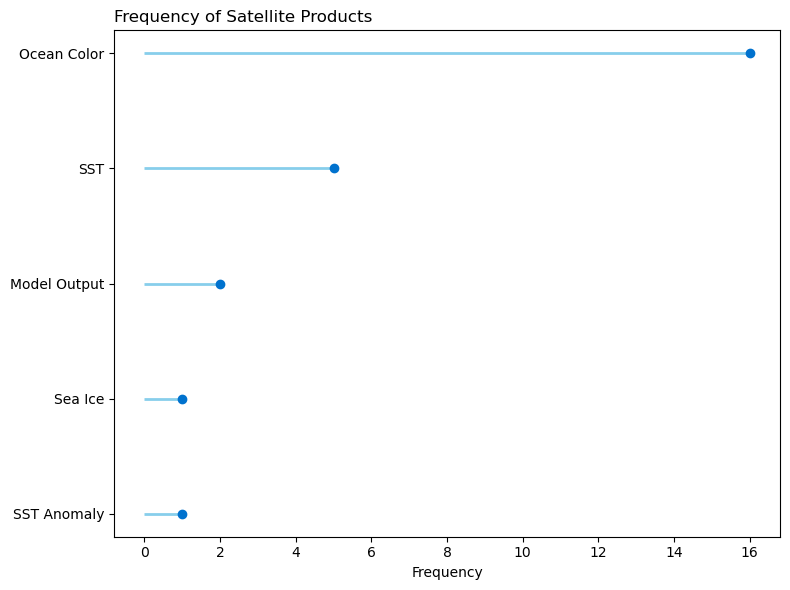

In [16]:
lollipop_chart_from_column(
    metadata_df, "Products", title="Frequency of Satellite Products"
)

## Visualize the Frequency of Topics used with a Lollipop Chart

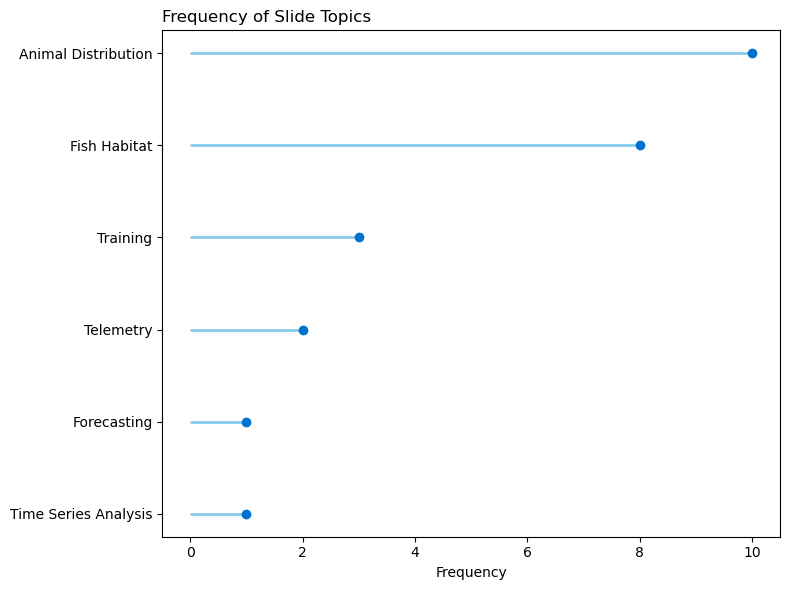

In [17]:
lollipop_chart_from_column(
    metadata_df, "Topic", title="Frequency of Slide Topics"
)

## Filter Slides by Keyword in Metadata Columns

The `filter_slide_columns()` function helps you find specific slides by filtering the ERDDAP metadata using **partial keyword matching**. In this tutorial, we want to include every slide that uses an Ocean Color product so we specify **Ocean Color** as the keyword and **Products** as the column inside the **metadata_df**.

Here are some additional examples of how to use the function:

-   You want to find all slides that mention a specific topic (e.g., "Fish Habitat")
-   You’re looking for slides that involve a certain software tool (e.g., "R" or "Python")
-   You need more flexibility than ERDDAP's web filters


In [18]:
# Filter metadata for slides using an Ocean Color Product
filtered_metadata = filter_slide_columns(
    metadata_df, ["Ocean Color"], column="Products"
)
print(filtered_metadata)

             ID  Year          Affiliation                   Products  \
177   2013wcn35  2013  NMFS/NEFSC/READ/PSB                Ocean Color   
180    2013wcn6  2013           NMFS/SEFSC                Ocean Color   
195    2014wcn2  2014       NMFS/NWFSC/FED                Ocean Color   
199    2014wcn5  2014           NMFS/SEFSC                Ocean Color   
204    2015wcn1  2015           NMFS/SWFSC           SST, Ocean Color   
222   2016wcn17  2016           NMFS/SEFSC                Ocean Color   
228   2016wcn22  2016      NMFS/AFSC/REFMD                Ocean Color   
242   2016wcn35  2016           NMFS/SWFSC           SST, Ocean Color   
244    2016wcn5  2016       NMFS/AFSC/RACE                Ocean Color   
258   2017wcn18  2017       NMFS/NWFSC/CBD           Ocean Color, SST   
270    2017wcn4  2017       NMFS/NWFSC/CBD           Ocean Color, SST   
331    2018wcn4  2018            NMFS/AFSC       Ocean Color, Sea Ice   
416    2019wcn4  2019        NMFS/AFSC/ABL         

# Prepare Metadata for PowerPoint Slides
* Create a list of the unique slide IDs
* Choose and extract the columns from the metadata that you want to use for titles of the powerpoint slides. You can join any metadata elements to form the title by including the column headers in the **columns_for_title** list in the next cell. For our example we chose "Topic". 
* OPTIONAL: uncomment **columns_for_bottom** to join additional metadata elements to add a footer to the slide.

In [ ]:
# Create a copy of the metadata DataFrame
selected_metadata = filtered_metadata.copy()

# Define columns to be used for slide titles
columns_for_title = ["Topic"]

# Define columns to be used for the bottom text
# columns_for_bottom = ["Products"]

# Extract only the selected columns for PowerPoint text
metadata_for_ppt = selected_metadata[columns_for_title]

# Retrieve slide IDs for image lookup
selected_ids = selected_metadata["ID"].tolist()

# Print the selected slide IDs
print(f"Selected Metadata IDs: {selected_ids}")

Selected Metadata IDs: ['2013wcn35', '2013wcn6', '2014wcn2', '2014wcn5', '2015wcn1', '2016wcn17', '2016wcn22', '2016wcn35', '2016wcn5', '2017wcn18', '2017wcn4', '2018wcn4', '2019wcn4', '2020owcp23', '2020owcp25', '2021wcn13']


# Generate Slide Image URLs

Construct URLs for each slide image based on the slide IDs retrieved from the metadata.

In [20]:
# Base URL for accessing slide images
slide_base_url = (
    "https://coastwatch.pfeg.noaa.gov/wcn/erddap/files/course_slide_deck/"
)

# Generate full image URLs for each slide ID
slide_urls = [f"{slide_base_url}{slide_id}.png" for slide_id in selected_ids]

## Download Slide Images in Parallel

Download the slides images concurrently to decrease run time. It could take several minutes to download the slides.

In [21]:
# Download all images in parallel
images = parallel_download_images(session, slide_urls)
print("Slide download completed")

Slide download completed


## Create a PowerPoint Presentation

If you defined **columns_for_bottom** above, be sure to uncomment the code below to display the metadata on the slide. 

In [ ]:
prs = Presentation()
prs.slide_width = Inches(16)
prs.slide_height = Inches(9)

fixed_img_width = Inches(11)
fixed_img_height = Inches(6.0)
default_img_top = Inches(2.0)


for i, slide_id in enumerate(selected_metadata["ID"]):
    slide_url = f"{slide_base_url}{slide_id}.png"
    if slide_url not in images:
        continue  # Skip if image download failed

    img_data = images[slide_url]

    # Open image with PIL to resize efficiently and add a border
    with Image.open(img_data) as img:
        img_with_border = ImageOps.expand(img, border=5, fill="black")

        target_pixel_size = (1100, 600)
        resized_img = img_with_border.resize(target_pixel_size, Image.LANCZOS)

        temp_bytes = BytesIO()
        resized_img.save(temp_bytes, format="PNG")
        temp_bytes.seek(0)

        # orig_width, orig_height = img.size
        # aspect_ratio = orig_width / orig_height

    blank_slide_layout = prs.slide_layouts[5]
    slide = prs.slides.add_slide(blank_slide_layout)

    # Construct slide title
    metadata_text = "\n".join(
        [
            f"{col}: {metadata_for_ppt[col].values[i]}"
            for col in metadata_for_ppt.columns
        ]
    )

    title_shape = slide.shapes.title
    if title_shape:
        title_shape.text_frame.clear()  # Clears any existing text to prevent duplication

        # Reposition title text box at the top
        title_shape.left = Inches(0.2)
        title_shape.top = Inches(0.2)  # Keep at top of slide
        title_shape.width = prs.slide_width - Inches(0.4)
        title_shape.height = Inches(1.2)  # Adjust text box height

        # Add text as a single paragraph
        paragraph = title_shape.text_frame.add_paragraph()
        paragraph.text = metadata_text

        # Ensure font size is uniform
        font_size = Pt(32) if len(metadata_text) < 300 else Pt(24)
        for run in paragraph.runs:
            run.font.size = font_size

    # Center the image properly
    left = (prs.slide_width - fixed_img_width) / 2  # Center the image

    # Reset the image data stream before inserting into PowerPoint
    # img_data.seek(0)

    # Add image while keeping uniform size
    img = slide.shapes.add_picture(
        temp_bytes,
        left,
        default_img_top,
        width=fixed_img_width,
        height=fixed_img_height,
    )

    # Create bottom text using selected metadata columns
    # bottom_text = " | ".join(
    # [
    #    f"{col}: {selected_metadata[col].values[i]}"
    #    for col in columns_for_bottom
    # ]
    # )

    # Add a centered text box at the bottom of the slide
    # footer_width = prs.slide_width - Inches(0.4)

    # bottom_textbox = slide.shapes.add_textbox(
    #    left=(prs.slide_width - footer_width) / 2,
    #    top=prs.slide_height - Inches(1.0),
    #    width=footer_width,
    #    height=Inches(0.8),
    #    )

    # bottom_tf = bottom_textbox.text_frame
    # bottom_tf.clear()

    # bottom_paragraph = bottom_tf.paragraphs[0]
    # bottom_paragraph.text = bottom_text
    # bottom_paragraph.font.size = Pt(18)
    # bottom_paragraph.alignment = PP_ALIGN.CENTER

## Save the PowerPoint File

Update **output_file** path to where you want the PowerPoint saved and change the name as well.

In [32]:
output_file = "./new_course_slides_py.pptx"
prs.save(output_file)
print(f"Presentation saved as {output_file}")

Presentation saved as ./new_course_slides_py.pptx
